In [9]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [4]:
# Define test transforms (must match training)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Path to test data (local only)
test_data_path = '/kaggle/input/pneumonia-tb-dataset/Combined_Dataset_12856/Combined_Dataset_12856/Test'

test_dataset = datasets.ImageFolder(test_data_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Function to load a model and its weights
def load_model(model_name, num_classes, weights_path, device='cuda'):
    if model_name == 'densenet121':
        model = models.densenet121(weights=None)
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
    elif model_name == 'resnet50':
        model = models.resnet50(weights=None)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
    elif model_name == 'resnet101':
        model = models.resnet101(weights=None)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=None)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
    elif model_name == 'efficientnet_b4':
        model = models.efficientnet_b4(weights=None)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
    else:
        raise ValueError(f"Unknown model: {model_name}")
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [6]:
# List of model names and corresponding weight paths
model_names = ['densenet121', 'resnet50', 'resnet101', 'efficientnet_b0', 'efficientnet_b4']
num_classes = 3
model_dir = '/kaggle/working/model_results'

# Map model names to their best weights
model_weights = {
    name: os.path.join(model_dir, name, f'{name}_best.pth') for name in model_names
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
ensemble_models = []
for name in model_names:
    print(f"Loading {name}...")
    model = load_model(name, num_classes, model_weights[name], device=device)
    ensemble_models.append(model)
print("All models loaded.")

Loading densenet121...
Loading resnet50...
Loading resnet101...
Loading efficientnet_b0...
Loading efficientnet_b4...
All models loaded.


In [10]:
# Evaluate and visualize ensemble using the same function as in chestxray-classification notebook
def evaluate_and_plot_model(model, test_loader, trainAcc, trainLoss, valAcc, valLoss, class_names, device='cuda', model_name='model', y_true=None, y_pred=None, y_prob=None, output_dir=None):
    if output_dir is None:
        output_dir = os.path.join('model_results', model_name)
    os.makedirs(output_dir, exist_ok=True)
    if y_true is None or y_pred is None or y_prob is None:
        # Fallback to model-based inference if not provided
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for X, y in test_loader:
                X = X.to(device)
                y = y.to(device)
                outputs = model(X)
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                all_preds.append(preds.cpu())
                all_labels.append(y.cpu())
                all_probs.append(probs.cpu())
        y_true = torch.cat(all_labels).numpy()
        y_pred = torch.cat(all_preds).numpy()
        y_prob = torch.cat(all_probs).numpy()
    # Plot 1: Accuracy & Loss (skipped for ensemble)
    # Plot 2: Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{output_dir}/{model_name}_confusion_matrix.png')
    plt.close()
    # Print classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f'{output_dir}/{model_name}_classification_report.csv')
    print("Classification Report:")
    print(df_report)
    # Binarize labels for ROC & PR curve
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    # Plot 3: ROC Curve and AUC
    plt.figure()
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        auc_score = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.savefig(f'{output_dir}/{model_name}_roc_curve.png')
    plt.close()
    # Plot 4: Precision-Recall Curve
    plt.figure()
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
        ap_score = average_precision_score(y_true_bin[:, i], y_prob[:, i])
        plt.plot(recall, precision, label=f"{class_names[i]} (AP = {ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.savefig(f'{output_dir}/{model_name}_precision_recall_curve.png')
    plt.close()
    # Save metrics as JSON
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'classification_report': report
    }
    with open(f'{output_dir}/{model_name}_metrics.json', 'w') as f:
        json.dump(metrics, f)

# Call the function for the ensemble
ensemble_dir = os.path.join('model_results', 'ensemble')
evaluate_and_plot_model(
    model=None,
    test_loader=test_loader,
    trainAcc=None,
    trainLoss=None,
    valAcc=None,
    valLoss=None,
    class_names=test_dataset.classes,
    device=device,
    model_name='ensemble',
    y_true=all_labels,
    y_pred=ensemble_preds,
    y_prob=ensemble_probs,
    output_dir=ensemble_dir
)


Classification Report:
              precision    recall  f1-score     support
Normal         0.987879  0.962598  0.975075   508.00000
Pneumonia      0.965675  0.988290  0.976852   427.00000
TB             0.988636  0.997135  0.992867   349.00000
accuracy       0.980530  0.980530  0.980530     0.98053
macro avg      0.980730  0.982674  0.981598  1284.00000
weighted avg   0.980701  0.980530  0.980502  1284.00000


In [1]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import models as m
import torch.nn as nn
from tqdm import tqdm

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
#path for normal imgs
tb_normal_dir = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal"

## Paths for TB imgs
tb_tb_dir = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis"

# Paths for Pneumonia imgs
pneu_pneumonia_dir = "/kaggle/input/pneumonia-xray-images/test/opacity"

In [6]:
# Destination merged folder
merged_dir = "/kaggle/working/merged_dataset"
os.makedirs(merged_dir, exist_ok=True)

# Create class folders
for cls in ['Normal', 'Pneumonia', 'TB']:
    os.makedirs(os.path.join(merged_dir, cls), exist_ok=True)

In [7]:
def copy_images(src_dir, dest_dir, prefix=""):
    if not os.path.exists(src_dir):
        print(f"Source directory not found: {src_dir}")
        return
    for fname in os.listdir(src_dir):
        src_path = os.path.join(src_dir, fname)
        if os.path.isfile(src_path):
            dst_path = os.path.join(dest_dir, prefix + fname)
            shutil.copy2(src_path, dst_path)

In [8]:
# Copy Normal images
copy_images(tb_normal_dir, os.path.join(merged_dir, "Normal"), prefix="tb_")
# Copy Pneumonia images
copy_images(pneu_pneumonia_dir, os.path.join(merged_dir, "Pneumonia"), prefix="pneu_")
# Copy TB images
copy_images(tb_tb_dir, os.path.join(merged_dir, "TB"), prefix="tb_")

In [9]:
print(f"Normal images: {len(os.listdir(os.path.join(merged_dir, 'Normal')))}")
print(f"Pneumonia images: {len(os.listdir(os.path.join(merged_dir, 'Pneumonia')))}")
print(f"Tb images: {len(os.listdir(os.path.join(merged_dir, 'TB')))}")

Normal images: 3500
Pneumonia images: 390
Tb images: 700


In [16]:
# --- CONFIG ---
ENSEMBLE_DIR = "/kaggle/working/model_results/ensemble_unseen"
NEW_DATA_DIR = "/kaggle/working/merged_dataset" 
BATCH_SIZE = 32
CLASSES = ['Normal', 'Pneumonia', 'TB']

In [12]:
# --- TRANSFORMS ---
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

test_transforms = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [13]:
# --- LOAD NEW DATASET ---
new_data = datasets.ImageFolder(NEW_DATA_DIR, transform=test_transforms)
new_loader = DataLoader(new_data, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
# --- LOAD ENSEMBLE MODEL ---
def get_custom_classifier(in_features, num_classes=3):
    return nn.Sequential(
        nn.Linear(in_features, 512),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(32, num_classes)
    )

In [23]:
# --- ENSEMBLE LOADING---
def get_in_features(model, classifier_attr):
    layer = getattr(model, classifier_attr)
    if isinstance(layer, nn.Sequential):
        for sublayer in layer:
            if isinstance(sublayer, nn.Linear):
                return sublayer.in_features
        raise ValueError("No Linear layer found in Sequential classifier.")
    else:
        return layer.in_features

In [24]:
ENSEMBLE_MODELS = {
    'resnet50': {
        'arch': lambda: m.resnet50(weights=None),
        'weight_path': '/kaggle/working/model_results/resnet50/resnet50_best.pth',
        'classifier_attr': 'fc',
    },
    'densenet121': {
        'arch': lambda: m.densenet121(weights=None),
        'weight_path': '/kaggle/working/model_results/densenet121/densenet121_best.pth',
        'classifier_attr': 'classifier',
    },
    'efficientnet_b0': {
        'arch': lambda: m.efficientnet_b0(weights=None),
        'weight_path': '/kaggle/working/model_results/efficientnet_b0/efficientnet_b0_best.pth',
        'classifier_attr': 'classifier',
    },
    'efficientnet_b4': {
        'arch': lambda: m.efficientnet_b4(weights=None),
        'weight_path': '/kaggle/working/model_results/efficientnet_b4/efficientnet_b4_best.pth',
        'classifier_attr': 'classifier',
    },
    'resnet101': {
        'arch': lambda: m.resnet101(weights=None),
        'weight_path': '/kaggle/working/model_results/resnet101/resnet101_best.pth',
        'classifier_attr': 'fc',
    },
}

In [25]:
def load_ensemble_models(device=DEVICE, num_classes=len(CLASSES)):
    models_list = []
    for info in ENSEMBLE_MODELS.values():
        model = info['arch']()
        in_feats = get_in_features(model, info['classifier_attr'])
        setattr(model, info['classifier_attr'], get_custom_classifier(in_feats, num_classes))
        model.load_state_dict(torch.load(info['weight_path'], map_location=device))
        model.to(device)
        model.eval()
        models_list.append(model)
    return models_list

In [26]:
# --- INFERENCE ---
all_preds = []
all_labels = []
all_probs = []

ensemble_models = load_ensemble_models(device=DEVICE, num_classes=len(CLASSES))

with torch.no_grad():
    for X, y in tqdm(new_loader, desc='Testing', leave=True):
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        probs_list = []
        for model in ensemble_models:
            outputs = model(X)
            probs = torch.softmax(outputs, dim=1)
            probs_list.append(probs)
        avg_probs = torch.stack(probs_list).mean(dim=0)
        preds = torch.argmax(avg_probs, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())
        all_probs.append(avg_probs.cpu())

y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()
y_prob = torch.cat(all_probs).numpy()

Testing: 100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


In [27]:
# --- PLOTS & METRICS ---
os.makedirs(ENSEMBLE_DIR, exist_ok=True)

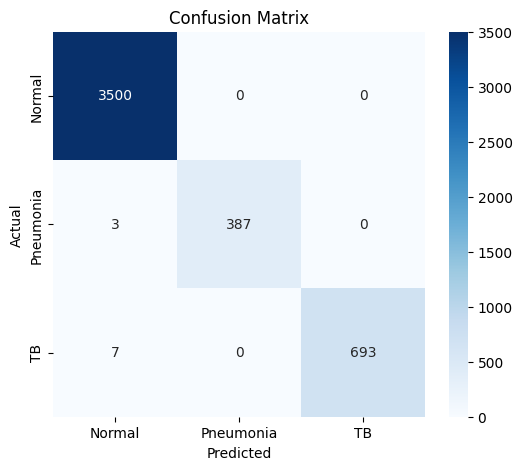

In [35]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(f'{ENSEMBLE_DIR}/ensemble_new_confusion_matrix.png')
plt.show()

In [29]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv(f'{ENSEMBLE_DIR}/ensemble_new_classification_report.csv')
print("Classification Report:")
print(df_report)

Classification Report:
              precision    recall  f1-score      support
Normal         0.997151  1.000000  0.998573  3500.000000
Pneumonia      1.000000  0.992308  0.996139   390.000000
TB             1.000000  0.990000  0.994975   700.000000
accuracy       0.997821  0.997821  0.997821     0.997821
macro avg      0.999050  0.994103  0.996562  4590.000000
weighted avg   0.997828  0.997821  0.997818  4590.000000


In [30]:
# Binarize labels for ROC & PR curve
y_true_bin = label_binarize(y_true, classes=list(range(len(CLASSES))))
y_true_bin = np.asarray(y_true_bin)

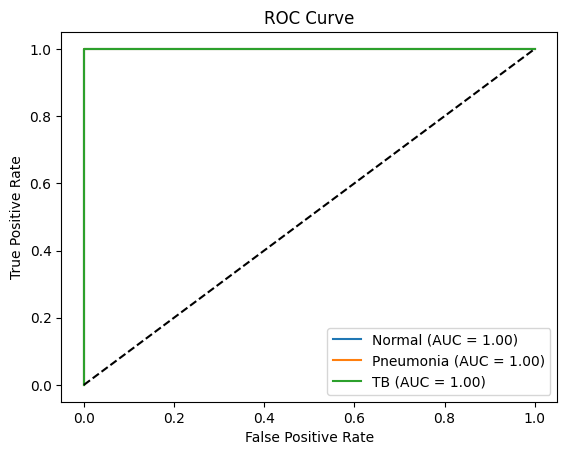

In [34]:
# ROC Curve
plt.figure()
for i in range(len(CLASSES)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    auc_score = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"{CLASSES[i]} (AUC = {auc_score:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(f'{ENSEMBLE_DIR}/ensemble_new_roc_curve.png')
plt.show()

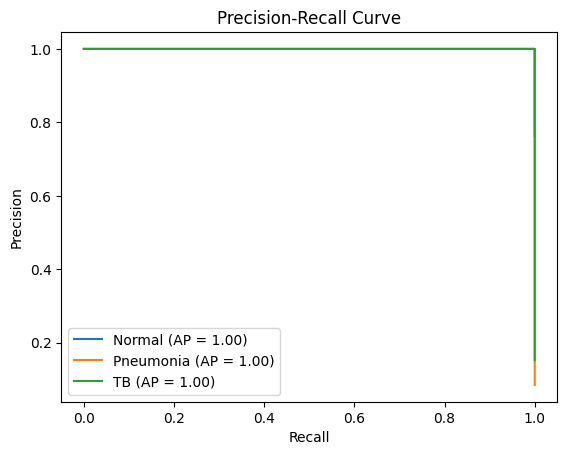

In [36]:
# Precision-Recall Curve
plt.figure()
for i in range(len(CLASSES)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap_score = average_precision_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"{CLASSES[i]} (AP = {ap_score:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.savefig(f'{ENSEMBLE_DIR}/ensemble_new_precision_recall_curve.png')
plt.show()